# Deep learning
---------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset whose goal is to classify handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(
        Conv2D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(28, 28, 1),
        )
    )
    model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(units=10, activation="softmax"))
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=5, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym="NN", fullname="Neural network")

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

data = (X_train, y_train), (X_test, y_test)

## Run the pipeline

In [5]:
atom = ATOMClassifier(*data, n_rows=0.1, n_jobs=6, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 6 cores.

Dataset stats ==================== >>
Shape: (7000, (28, 28, 1), 2)
-------------------------------------
Train set size: 6000
Test set size: 1000
-------------------------------------
|    |     dataset |       train |        test |
| -- | ----------- | ----------- | ----------- |
| 0  |   726 (1.2) |   633 (1.2) |    93 (1.1) |
| 1  |   765 (1.3) |   652 (1.3) |   113 (1.4) |
| 2  |   710 (1.2) |   609 (1.2) |   101 (1.2) |
| 3  |   713 (1.2) |   602 (1.2) |   111 (1.3) |
| 4  |   691 (1.2) |   599 (1.2) |    92 (1.1) |
| 5  |   596 (1.0) |   513 (1.0) |    83 (1.0) |
| 6  |   668 (1.1) |   567 (1.1) |   101 (1.2) |
| 7  |   725 (1.2) |   624 (1.2) |   101 (1.2) |
| 8  |   692 (1.2) |   592 (1.2) |   100 (1.2) |
| 9  |   714 (1.2) |   609 (1.2) |   105 (1.3) |



In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
atom.head()

,Multidimensional feature,Target
0,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",3
1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
2,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",3
3,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",4
4,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0


In [7]:
# Every row in the column contains the data of one image
print(f"Shape of one image: {atom.iloc[0, 0].shape}")
print(f"atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

Shape of one image: (28, 28, 1)
atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [8]:
# Like any other model, we can define custom dimensions for the bayesian optimization
atom.run(
    models=model,
    metric="f1_weighted",
    n_calls=5,
    bo_params={
        "dimensions": [Categorical([32, 64, 128, 256], name="batch_size")],
        "max_time": 120,
    }
)


Training ========================= >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
| call             | batch_size | f1_weighted | best_f1_weighted |    time | total_time |
| ---------------- | ---------- | ----------- | ---------------- | ------- | ---------- |
| Initial point 1  |         64 |      0.9526 |           0.9526 | 34.177s |    34.180s |
| Initial point 2  |         64 |      0.9526 |           0.9526 |  0.001s |    34.349s |
| Initial point 3  |        128 |      0.9533 |           0.9533 | 23.499s |    57.898s |
| Initial point 4  |         64 |      0.9526 |           0.9533 |  0.001s |    57.947s |
| Initial point 5  |        128 |      0.9533 |           0.9533 |  0.000s |    57.995s |

Results for Neural network:         
Bayesian Optimization ---------------------------
Best call --> Initial point 3
Best parameters --> {'batch_size': 128}
Best evaluation --> f1_weighted: 0.9533
Time elapsed: 58.131s
Fit -----------------------------------------

## Analyze the results

In [9]:
# Use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[8.32745670e-14, 4.03909371e-11, 2.39146132e-13, ...,
        5.99381433e-09, 1.62837044e-09, 1.22757385e-14],
       [9.99999166e-01, 4.09230863e-13, 2.47164795e-08, ...,
        5.39234435e-10, 1.17979056e-07, 4.89375597e-12],
       [5.94590262e-17, 1.59245773e-15, 1.57664645e-10, ...,
        2.82419799e-09, 7.11853493e-11, 2.59625690e-08],
       ...,
       [1.29603634e-17, 4.96066413e-15, 9.68647729e-19, ...,
        5.38861026e-16, 4.13599732e-09, 2.85001779e-11],
       [7.66431398e-08, 3.70914470e-17, 2.34945361e-08, ...,
        2.30101752e-14, 1.64613359e-13, 1.34364635e-15],
       [2.47110190e-08, 2.69764069e-15, 3.62205590e-08, ...,
        9.41424894e-09, 9.99999404e-01, 5.29901811e-08]], dtype=float32)

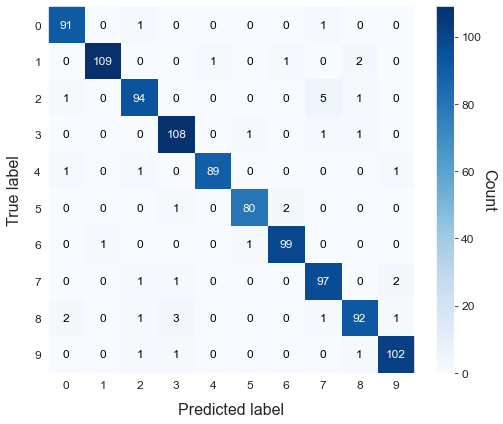

In [10]:
# Or make plots...
atom.nn.plot_confusion_matrix()